# Machine Learning the Iris set example -- GA





In [1]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets # import datasets
import numpy as np # import numpy
import matplotlib.pyplot as plt # import plots
import pandas as pd

# set the seed for the random number generator
mySeed=1234567

# load data
iris = datasets.load_iris() # load data 
X = iris.data # get features
y = iris.target # get targets
#print(iris.DESCR) # print dataset description

## 1. Exploratory Data Analysis

The first part of tackling any ML problem is visualising the data in order to understand some of the properties of the problem at-hand. The code below loads the iris dataset for you. With only 4 features (sepal length, sepal width, petal length, and petal width), and 3 classes, it is possible to use scatter plots to visualise interactions between different pairings of features. 

In [2]:
# define plotting function

# FIX AXES COMMENTS

def myplotGrid(X,y):
    #set up the grid
    fig,a =  plt.subplots(4,4, figsize = (14,14))
    #x = np.arange(1,11)
    #create data from X and y we have to slice and group the original data
    #the question here is how to do this
    #for each combination break up the points into 3 groups according to y
 
    col = ["green", "red", "blue"]
     
    for f1 in range(0,4):
        for f2 in range(0,f1):
            if f1 != f2: 
                for i in range(0,3):
                    a[f1][f2].scatter(X[(y==i)][:,f2], X[(y==i)][:,f1], alpha = 0.7, color=col[i])
                    a[f2][f1].scatter(X[(y==i)][:,f1], X[(y==i)][:,f2], alpha = 0.7, color=col[i])
        
        a[f1][f1].hist(X[:,f1], 10, facecolor="blue", alpha = 0.5)

  
    
    plt.show()
    
    return None


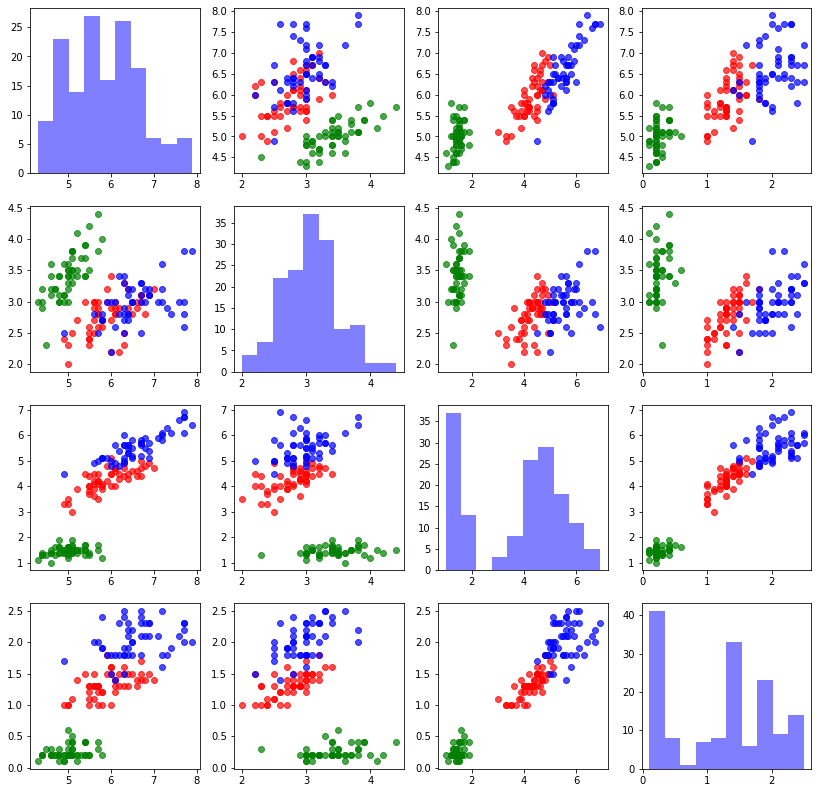

In [3]:
# run the plotting function
myplotGrid(X,y)

### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings they usually contain some amount of noise that makes classification more challenging. In the cell below, invoke your exploratory data analysis function above on a noisy version of your data X.

Try to perturb your data with some Gaussian noise,

    # initialize random seed to replicate results over different runs
    np.random.seed(mySeed) 
    XN=X+np.random.normal(0,0.5,X.shape)
    
and then invoke

    myplotGrid(XN,y)

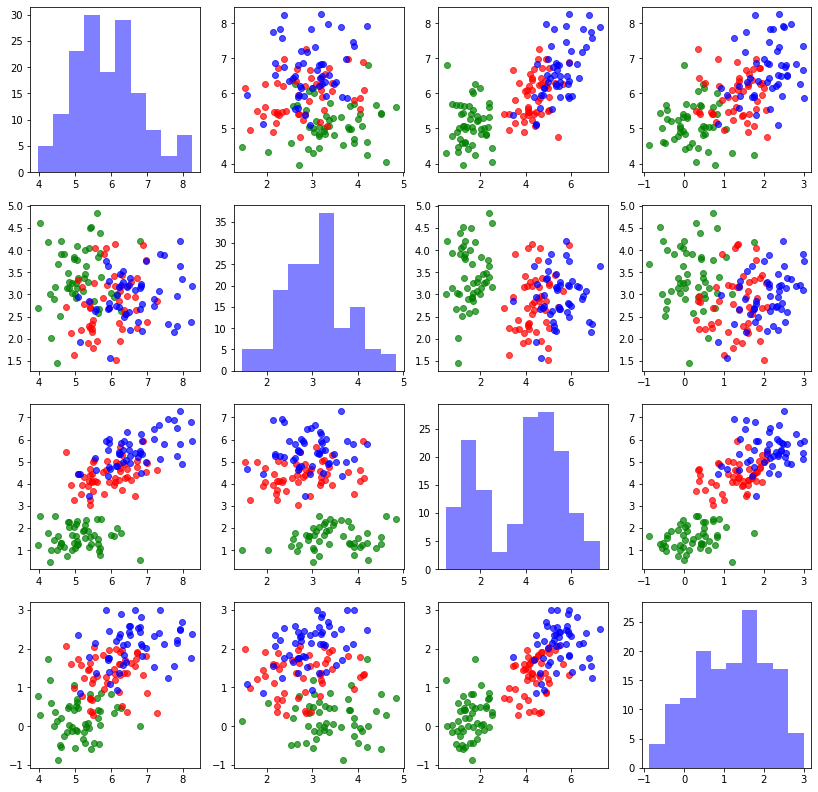

In [4]:
# noise code 
np.random.seed(mySeed) 
XN=X+np.random.normal(0,0.5,X.shape)
myplotGrid(XN,y)

## 2. Implementing kNN 

In the cell below, I develop my  own code for performing k-Nearest Neighbour classification.  


In [5]:
# helper code

#A function that gives the distance between two vectors 
#Using the Euclidean distance
#The vectors are assumed to be numpy arrays
def adist(a,b):   
    '''This function calculates the Euclidian distance between np vectors a and b'''
    assert len(a) == len(b)
    return np.sqrt(((a-b)**2).sum())
  
def bdist(a,b):   
    '''This function calculates the Manhattan distance between np vectors a and b'''
    assert len(a) == len(b)
    return np.absolute(a-b).sum()

#A function that uncovers the nearest neighbours to a given vector
#It must return the nearest K vectors ?
#The inputs must be a 2-d array A, a 1-d array X and a number K, each single vector is a row so it must be that length
#of X is equal to the number of columns of A i.e. to the length of A's rows
#also the distance funtcion should be an input
#The output can be a boolean array Y with True in the places where the nearest vectors are and the length of Y should be equal to
#the number of rows of A matrix

def find1(A, X, K, dist):
    '''Returns a Boolean vector (np.array) with the positions of the K closest rows from A to the vector X as measured with metric dist'''
    distances = [dist (row, X) for row in A ] #the list of all distances
    distances = np.array(distances) #convert the list to np.array

    #np.argsort returns the indices that would sort the array in increasing order

    K_sorted_indices = np.argsort(distances)[:K]

    #A boolean index Y can be used to indicate where the K closest are located within A
    Y = np.array([], dtype = 'bool')

    for i in range(0,len(A)):

        if i in K_sorted_indices:
            Y = np.append(Y, True)  
        else:
            Y = np.append(Y, False)

    return Y 



In [6]:
import random
random.seed(1234567)
# I am aware that this is the python and not the numpy random generator but it will be useful later to shuffle


def mykNN(X,y,X_, K_, dist_):
    
    '''Returns a vector of predictions for the target class using the K_  nearest neighbours, the metric dist_, with features X and target y.
    '''
    
    #For each vector in X_, Counter keeps count of the classes of the K_ vectors nearest to it with the given metric
    #Here the dimension of Counter is 3 because there are 3 possible classes for the target but in principle this could be different
    Counter = np.zeros(3, dtype = int)
    #holds the model predictions
    pred = np.array([], dtype = int)
   
    for x in X_:
        Counter[:] = 0
        Y = np.array(find1(X, x, K_, dist_))
        #get the y's where Y is True. There will be K_ of them by construction
        #add each of them to the appropriate counter
        Y1 = y[Y==1]  #just look at the targets of the closest vectors
        assert len(Y1) == K_
        for i in range(0,K_): #for each of the Trues
            for  k in range(0,3):
                if Y1[i] == k:                    
                    Counter[k]=Counter[k]+1
                    
        pred =np.append( pred, np.argsort(Counter)[-1])

    #the prediction is the y corresponding to the counter position where the highest count is stored
    

    return pred






## 3. Evaluation 

In the cell below, I implement my  own classifier evaluation code. This should include some way of calculating confusion matrices, as well as common metrics like accuracy. 

I will write some additional code that lets you display the output of your confusion matrices in a useful and easy-to-read manner.

I will test my functions on some test data, and compare the results to the sklearn library versions. 


In [7]:
# confusion matrix code

def My_con_mat(y, y_pred):
    '''
    Given the actual and predicted y's this funtion returns a dataframe representing the confusion matrix.
    '''
    
    df = pd.DataFrame(zip(y, y_pred), columns=['y','y_pred'])
    df2=pd.crosstab(df['y'], df['y_pred'], rownames=['Act  '], colnames=['    Pred'])
    
    return df2



def my_metrics(conmat):

    '''
    Given a confusion matrix it calculates and returns the accuracy, precision, recall and f1-score as a list of two elements.
    The first element returned is a dataframe containing presision, recall and f1-score for each of class.
    The second element returned is the accuracy rounded to 3 digits.
    '''
    #implement accuracy
    diag =np.diag(conmat).sum()
    all = conmat.sum().sum()
    acc = diag/all
    

    # implement precision, recall and f1-score
    # precision  = tp/ (tp+fp) etc, as in Note below
    # when we have a confusion matrix, for each of the rows tp is the diagonal element
    # and fp is the predicted as x while it is not actually x,  that is, tp + fp is the column sum, similarly for recall 
    # so precision is diag el/column sum and recall = diag el/ row sum
    
    
    colsums = conmat.sum(axis = 0)
    rowsums = conmat.sum(axis = 1)

    prf = pd.DataFrame(columns =['Precision', 'Recall', 'f1-score'])

    
    for i in range(len(CM)):
        
        r = conmat.iloc[i,i]/rowsums[i]
        p = conmat.iloc[i,i]/colsums[i]
        f1 = 2*r*p/(r+p)
        prf.loc[len(prf)] = [p,r,f1]
        

    return [prf , round(acc,3)]


In [8]:
y_= mykNN(X,y,X, 5, adist)
CM = My_con_mat(y, y_)
stats = my_metrics(CM)
print('\n', stats[0])
print('\n', 'accuracy = ', stats[1])
print(my_metrics.__doc__)


    Precision  Recall  f1-score
0   1.000000    1.00  1.000000
1   0.959184    0.94  0.949495
2   0.941176    0.96  0.950495

 accuracy =  0.967

    Given a confusion matrix it calculates and returns the accuracy, precision, recall and f1-score as a list of two elements.
    The first element returned is a dataframe containing presision, recall and f1-score for each of class.
    The second element returned is the accuracy rounded to 3 digits.
    


**Note**

Precision and recall are defined as:

${\displaystyle {\text{Precision}}={\frac {tp}{tp+fp}}\,}
$
$
{\displaystyle {\text{Recall}}={\frac {tp}{tp+fn}}\,}
$



f1-score is defined as:

${\displaystyle {\text{f1-score}}={\frac {2\, \text{Precision}\, \text{Recall} } {\text{Precision}\,+\,\text{Recall}}     }}
$





## 4. Nested Cross-validation using your implementation of KNN  

In the cell below, I develop my own code for performing 5-fold nested cross-validation along with your implemenation of k-NN above. The scikit-learn module will only be used for verification purposes. 




In [9]:
import random

def myNestedCrossVal(X,y,nofolds,Klist,Distlist,mySeed):
    '''
    This function performs the cross validation of myKNN algorithm with inputs the data, number of folds, number of
    neighbouring points, metrics and random seed.
    
    The function returns a list of dataframe results [results0, results1, results2, results] that represent respectively:
    
        results0 -- the parameters and accuracy achieved in each run 
        results1 -- the mean accuracies achieved per fold
        results2 -- the best set of parameters and accuracy for each fold 
        results  -- all the results in results0 as well as the confusion matrix for each run 
    '''
    #In order to create the folds, randomly shuffle 150 numbers and then use these to draw elements from the data
    
    random.seed(mySeed)
    shuffled = list([i for i in range(0,150)])
    random.shuffle(shuffled)
    testsize = int(len(X)/nofolds) 
    assert testsize*nofolds == len(X)

    #This is where all resluts will be stored
    results = pd.DataFrame(columns = ['fold','accuracy', 'K', 'metric', 'CM' ])


    #for each fold, for each K, for each distance

    for fold1 in range(0, nofolds): #for each fold
        #choose the data in the fold
        list1 = shuffled[fold1*testsize: (fold1+1)*testsize]     
        X1 = X[list1]
        y1 = y[list1]
        X2 = np.delete(X, list1, 0)
        y2 = np.delete(y, list1, 0)
        
        for k in Klist: 
            #for each k run the knn and store all outputs in the results df
            #do the same for each distance, Eucl and Manh, since there are only two, no need for loop
            
            y_= mykNN(X1,y1,X2, k, Distlist[0])
            CM = My_con_mat(y_, y2)
            acc = round(my_metrics(CM)[1],3)
            i = len(results)+1
            results.loc[i] = [fold1+1, acc , k, 'Eucl', CM]
            
            y_= mykNN(X1,y1,X2, k, Distlist[1])
            CM = My_con_mat(y_, y2)
            acc = round(my_metrics(CM)[1],2)
            i = len(results)+1
            results.loc[i] = [fold1+1, acc , k, 'Manh', CM]  
    
    #Now all calculations are done and all results are stored in the results df
    #Below we do some processing to extract different information from this master df
    
    #results0 is the full list of accuracies per fold, number of neighbours and distance function
    results0 = results[['fold','accuracy', 'K', 'metric']]
    
    #results1 is per fold average accuracies 

    results1 = results0.groupby(['fold']).mean()
        

    results22=[] 
    for fold1 in range(1,nofolds+1):   
        # The below variables 00,11,22 are just intermediate variables used to make the steps clearer
        results00 = results0[results0['fold']==fold1 ]
        
        results11 = results00[results00['accuracy'] ==  results00['accuracy'].max()]

        results22.append(results11.values.tolist()[0]) 
        #Note that if there is more than one set of params with the highest accuracy, we choose the first  
  

    # We want to make results2  a dataframe
    results2 = pd.DataFrame(results22, columns = ['fold','accuracy', 'K', 'metric'])

    
    return [results0, results1, results2, results]
    

   
print(myNestedCrossVal.__doc__)




    This function performs the cross validation of myKNN algorithm with inputs the data, number of folds, number of
    neighbouring points, metrics and random seed.
    
    The function returns a list of dataframe results [results0, results1, results2, results] that represent respectively:
    
        results0 -- the parameters and accuracy achieved in each run 
        results1 -- the mean accuracies achieved per fold
        results2 -- the best set of parameters and accuracy for each fold 
        results  -- all the results in results0 as well as the confusion matrix for each run 
    


In [10]:
# evaluate clean data code
comparison = myNestedCrossVal(X,y,5, list(range(1,11)),[adist, bdist], 1234567)

In [11]:
#example of confusion matrix extracted from the function run above
comparison[3]['CM'][1]

Pred,0,1,2
Act,,,
0,37,0,0
1,0,43,7
2,0,1,32


***Comment:*** 

Obviously, any and all confusion matrices are available to print because they are now stored in the comparison[3] dataframe returned by the above funtion. 

In [17]:
#print the averages of the above calculations

print('\033[1m','Average accuracy per fold -- clean data', '\033[0m', '\n\n', comparison[1],'\n\n', 
      'mean accuracy = ', round(comparison[1]['accuracy'].mean(), 3), 'st dev =', round(comparison[1]['accuracy'].std(),3))
 
   
print('\n\n','\033[1m', 
      'Optimal parameters per fold -- clean data','\033[0m', '\n\n', pd.DataFrame(comparison[2]), '\n\n', 
      'mean accuracy = ', round(comparison[2]['accuracy'].mean(), 3), 'st dev =', round(comparison[2]['accuracy'].std(),3))



 Average accuracy per fold -- clean data  

       accuracy
fold          
1      0.91775
2      0.92910
3      0.95315
4      0.96615
5      0.95070 

 mean accuracy =  0.943 st dev = 0.02


  Optimal parameters per fold -- clean data  

    fold  accuracy  K metric
0     1     0.960  4   Manh
1     2     0.960  1   Manh
2     3     0.980  5   Manh
3     4     0.992  6   Eucl
4     5     0.970  5   Manh 

 mean accuracy =  0.972 st dev = 0.014


In [13]:
# evaluate noisy  data code

comparison1 = myNestedCrossVal(XN,y,5, list(range(1,11)),[adist, bdist], 1234567)

In [14]:
#print averages

print('\033[1m','Average accuracy per fold -- noisy data', '\033[0m', '\n\n', comparison1[1],'\n\n', 
      'mean accuracy = ', round(comparison1[1]['accuracy'].mean(), 3), 'st dev =', round(comparison1[1]['accuracy'].std(),3))
 
   
print('\n\n','\033[1m', 
      'Optimal parameters per fold -- noisy data','\033[0m', '\n\n', pd.DataFrame(comparison1[2]), '\n\n', 
      'mean accuracy = ', round(comparison1[2]['accuracy'].mean(), 3), 'st dev =', round(comparison1[2]['accuracy'].std(),3))


 Average accuracy per fold -- noisy data  

       accuracy
fold          
1      0.80400
2      0.82960
3      0.86715
4      0.83190
5      0.85160 

 mean accuracy =  0.837 st dev = 0.024


  Optimal parameters per fold -- noisy data  

    fold  accuracy   K metric
0     1     0.842   7   Eucl
1     2     0.867   5   Eucl
2     3     0.892   9   Eucl
3     4     0.880   5   Manh
4     5     0.900  10   Eucl 

 mean accuracy =  0.876 st dev = 0.023


## 5. Summary of results 

Using the results from above, I fill out the following table using the **clean** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 0.960  |  4 | Manh  |
| 2 | 0.960  |  1 | Manh  |
| 3 | 0.980  |  5 | Manh  |
| 4 | 0.992  |  6 | Eucl  |
| 5 | 0.970  |  5 | Manh  |
| **total** | 0.972 $\pm$ 0.014 |   |    |


***Comment:* These represent the optimal parameters per fold, it is just the same information generated from the code above**


Where **total** is given as an average over all the folds, and $\pm$ the standard deviation.

Now fill out the following table using the **noisy** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 0.842  |  7 | Eucl  |
| 2 | 0.867  |  5 | Eucl  |
| 3 | 0.892  |  9 | Eucl  |
| 4 | 0.880  |  5 | Manh  |
| 5 | 0.900  |  10 | Eucl  |
| **total** | 0.876 $\pm$ 0.023 |   |    |


***Comment:* These represent the optimal parameters per fold**

### 5.2. Confusion matrix summary



***Comment:***

From running the function ```myNestedCrossVal``` above for the two sets of data, clean and noisy, we already have all the confusion matrices for both sets of data. These are stored in variable results wich is returned by the function. It is not totally clear how we can "summarize" the confusion matrices. But I will assume we want to average the confusion matrices of clean data and then calculate the usual statistics on them. Then do the same for the noisy data. 

In [15]:
print('CLEAN -- Average of confusion matrices and derived metrics\n')
# clean data summary results

CM1 = comparison[3]['CM']
#CM1 is a series of dataframes with indices ranging from 1 to 100
CM2 = pd.DataFrame() #intermediate variable

for confmat in CM1:
    CM2 = pd.concat((CM2, confmat), axis =0)

data_mean=CM2.groupby(level=0).mean()
print(data_mean)
Clean_metrics = my_metrics(data_mean)
print('\naccuracy = ', Clean_metrics[1], '\n')
print(Clean_metrics[0],'\n\n')

#Do the same for Noisy data
print('NOISY -- Average confusion matrices and metrics\n')
CM1 = comparison1[3]['CM']
CM2 = pd.DataFrame()

for confmat in CM1:
    CM2 = pd.concat((CM2, confmat), axis =0)

data_mean=CM2.groupby(level=0).mean()
print(data_mean)
Clean_metrics = my_metrics(data_mean)
print('\naccuracy = ', Clean_metrics[1],'\n')
print(Clean_metrics[0])


CLEAN -- Average of confusion matrices and derived metrics

    Pred     0      1      2
Act                         
0         40.0   0.03   0.00
1          0.0  35.89   2.67
2          0.0   4.08  37.33

accuracy =  0.944 

   Precision    Recall  f1-score
0    1.00000  0.999251  0.999625
1    0.89725  0.930757  0.913697
2    0.93325  0.901473  0.917086 


NOISY -- Average confusion matrices and metrics

    Pred      0      1      2
Act                          
0         39.96   0.25   0.00
1          0.04  28.50   8.04
2          0.00  11.25  31.96

accuracy =  0.837 

   Precision    Recall  f1-score
0     0.9990  0.993783  0.996384
1     0.7125  0.779114  0.744320
2     0.7990  0.739644  0.768177


## 6. Questions 


### Q1. Exploratory data analysis
Looking again at the exploratory data analysis, what do you observe by plotting the figure for data without noise? What do you observe when you add Gaussian noise and plot again? 

**Answer:**

Looking at the clean data, we see that, mostly, the points of similar colour are concentrated together the sets of points are fairly separate from each other. In particular, the green points seem to be a distinct set in all plots. The blue and red set have some limited overlap. This would suggest that a classification algorithm based on the neighbouring points may work raasonably well. Looking at the noisy data the picture is somewhat different. The clusters of points are now more widely spread out because of the noise. For the same reason, there is more overlap in the different colours compared to the clean case. This would suggest that although looking at the k neighbouring points may still give reasonable results, it will not work as well as in the clean case. And this is exactly what the results of the analysis above confirm.

### Q2.	 Choice of parameters
In your implementation, do the best parameters change per fold? Can you say that one parameter choice is better regardless of the data used? 

**Answer:**

Clearly the best parameters change per fold as it can be seen from the above results. Different distance metrics and different number of neighbouring points give the best result for each fold. No two folds have the same optimal set of parameters. However, one can generally observe that for the clean data set, the optimal value for k looks to be around 5 and the best distance is the Manhattan distance. For the noisy set, it looks like higher values for k, closer to 10,  work better together with the Euclidean distance. 


### Q3. Clean vs. noisy
Does the best parameter choice change depending on whether we use clean or noisy data? (Answer for both distance function and number of neighbours.)

**Answer:**

Yes the optimal parameter choice, both distance function and number of neighbours, is almost completely different between each folds in the clean and noisy case. So, the parameter choice does depend on the use of clean vs noisy data because the structure of each set of data is different. As pointed out in the previous answer, one can generally observe that for the clean data set, the optimal value for k looks to be around 5 and the best distance is the Manhattan distance. For the noisy set, it looks like higher values for k, closer to 10,  work better together with the Euclidean distance. 



### Q4. Tie break
Assume that you have selected the number of neighbours to be an even number, e.g., 2. For one of the neighbours, the suggested class is 1, and for the other neighbour the suggested class is 2. How would you break the tie? Write example pseudocode that does this.

**Answer:**

There are many possible choices. What happens in the above code is that the choice in case of a tie depends on the structure of the set, it is not explicitly determined in the code. Another way would be to choose the class of the closest neighbour. In the case of two neighbours, it could work like this:

    if class(neighbour1) not the same as class(neighbour2):
    
    distance1 = distance(target, neighbour1)
    distance2 = distance(target, neighbour2)
       
       if distance1 < distance2 :
            class (target) = class(neighbour1)
       else:
            class (target) = class(neighbour2)
            



### Q5.	Beyond Iris 
If you were to run your k-nn algorithm on a new dataset, what considerations would you need to be taken into consideration? Outline any changes that might be needed to your code. 


**Answer:**

The first consideration would to ensure that all the functions work for arbitrary sizes of data sets and parameters, as right now there are some hardcoded parts, given that we deal with specific sets of data.

Second, it is important that there is some efficiency in memory management. Memory management considerations did not play a big role in the code written above because the working sets were small. But this could be important for really large data sets.

Third, more attention could be paid in speed optimization. Using the the most efficient types of data structures, for example. Using lists and np arrays instead of dataframes may in some cases speed up execution.

Fourth, some error trapping would need to be implemented.

Fifth, the design of the functions, should be revised. If the purpose is to reuse the functions in many different cases then each function should have a very specific purpose and not try to do too much, e.g. calculate many different quantities. Also, the function interfaces should be where the distance functions are passed. Maybe an algorithm class should be designed.

And so on...

